<h2> Introduction </h2>

In this kernel, we will use Gausian Process Regressions and Bayesian Optimisation on ecoacoustic metrics to quantify the spatiotemporal distribution of birds on-farm. The data was obtained by placing 20 audio recorders across the property in a grid formation. The biodiversity project was set up in 14 and 15th Nov 2019.


<h2> Our Goals </h2>

<ul>
<li> Understand the spatial and temporal variability in the data, in particular, study how avian species richness change, examine if there are seasonal cycles.
<li> Determine the optimal placement of the 20 audio recorders using the previously described methods. </li>
<li> Determine what the optimal placement would be if one or more of the recorders were to stop functioning. </li>
</ul>


<h2> Outline </h2>

I. <b>Our Toolbox</b><br>
a) [The PreProcessing Class](#preprocessingclass)<br>
b) [The EcouacousticModel Class](#ecoacousticmodelclass)<br>
&nbsp;&nbsp;&nbsp;&nbsp;(i) [The SingleFrameGaussianProcessModel Class](#singlegpclass)<br>
&nbsp;&nbsp;&nbsp;&nbsp;(ii) [The FullGaussianProcessModel Class](#fullgpclass)<br>
&nbsp;&nbsp;&nbsp;&nbsp;(iii) [The TSModel Class](#tsmodelclass)<br>
c) [The EcouacousticAnalysis Class](#ecoacousticanalysisclass)<br>
&nbsp;&nbsp;&nbsp;&nbsp;(i) [The Visualise Class](#visualiseclass)<br>
&nbsp;&nbsp;&nbsp;&nbsp;(ii) [The SVDModel Class](#svdmodelclass)<br>
&nbsp;&nbsp;&nbsp;&nbsp;(iii) [The SiteSelection Class](#siteselectionclass)<br>


II. <b>Understanding our data</b><br>
b) [Initializing and pre-processing our data](#initializing)<br>
b) [Gathering sense of our data](#gather)<br>


III. <b>Gaussian Process Regression spatiotemporal predictions</b><br>
a) [Picture: single timeframe spatial gaussian process regression predictions](#singlegp)<br>
b) [Video: spatiotemporal gaussian process regression predictions over the whole timeframe](#fullgp)<br>


IV. <b>Understanding the spatial and temporal variability in avian richness</b><br>
a) [Timeseries analysis](#tsmodel)<br>
b) [Spatiotemporal analysis?](#spatiotemporal)<br>

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
import statsmodels.api as sm
from itertools import product
import datetime as dt
from os.path import exists

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

import warnings
# warnings.filterwarnings("ignore")

<h2> I. Our Toolbox </h2>
<a id="preprocessingclass"></a>

<h3>a) The PreProcessing Class</h3>

<h3>a) The PreProcessing Class</h3>

This class was built not only rapidly prepare our data for modelling, but to also manipulate it in several ways, in order to allow us to test our models with different parametrizations, filtering techniques, and data selections. Each individual function will be explained: 

* `__init__(self, data_name, metadata_name, data_type)`: the first two inputs correspond to the files containing the data that we are going to work with. The third corresponds to the specific ecoacoustic metric that we are performing the analysis on.
    The initialization function reads the input files as DataFrames, and calls the "format_data" function to define the formatted data.
        
        
* `get_metadata(self)`:  the function sorts the "metadata_name" DataFrame by the "instrument_name" column, checks the names contained in the "data_name" table, and then returns a DataFrame that contains only the "instrument_name" that are contained in both of the input tables. 

        
* `get_names(self)`: returns an ordered list of the column "names", which corresponds to each individual name of the plots (see II.a to learn more about the raw data)  
   
    
* `get_single_frame_data(self, data, index)`: The input "data" should be a DataFrame with the ordered names of the plots as columns, the ordered times as rows, and the values of the table corresponding to "values" associated with the "data_type" that was chosen as input. Index should be an integer. 
    The output of the function is a DataFrame containing the latitudes, longitudes and values of each instrument, for a specific time. This time is determined by the index, which selects a row from the input "data".
   It is important to note that the input "data" is the output of another function of this class: get_current_cleaned_data, so the intended purpose of this function is to select the coordinates and associated values of a specific time.     
    
    
* `get_data_for_full_gp(self, data, av_each_date = True)`:  
   

* `get_single_site_data(self, data, name)`: the input "data" should be a DataFrame with the ordered names of the plots as columns, the ordered times as rows, and the values of the table corresponding to "values" associated with the "data_type" that was chosen as input. "name" should be a string, containing the name of one of the plots. 
    This function returns a Series containing the values that this plot has recorded for the whole timeframe. The Series is indexed with each individual time.    
   
    
* `format_data(self, data_type)`: the input "data_type" should be a string, containing the ecoacoustic metric that we want to perform the analysis on.
This function formats the data that was fed to the initialization function, and returns a DataFrame with the ordered names of the plots as columns, the ordered times as rows, and the values of the table corresponding to "values" associated with the "data_type" that was chosen as input.   
    
    
* `remove_plot(self)`:   
   
    
    
* `get_sections(self, current_data, name)`: the input "current_data" is a Dataframe with the ordered names of the plots as columns, the ordered times as rows, and the values of the table corresponding to "values" associated with the "data_type" that was chosen as input. "name" should be the name of one of the plots. 
   This function takes the time series of values of an individual plot, and returns two lists: the sections that don't contain zeros, and the sections of zeros. The purpose is to identify the periods of missing data for an individual plot.   
     
    
    
* `get_overlapping_intersections(self, current_data)`: the input "current_data" should be a Dataframe with the ordered names of the plots as columns, the ordered times as rows, and the values of the table corresponding to "values" associated with the "data_type" that was chosen as input. 
    This function takes the time series of a set of plots, and returns the times where all of these plots don't have missing values. 

    
    
* `get_intersection(self, range_1, range_2)`: the inputs "range_1" and "range_2" correspond to the beggining and end of the desired ranges that this function will use. 
    This function returns a list containing the intersection of the two ranges. If there is no intersection, it returns an empty list.


    
* `get_intersections(self, all_non_zero_sections)`: the input "all_non_zero_sections" is an output of the function "get_sections". It is a list containing the indexes for the sections of all the timeseries in the DataFrame that don't contain any zeros (which are missing values in the case of this DataFrame).
    This function returns a list containing the intersection of all these sections. 

    
* `get_current_cleaned_data(self)`: This function takes the output DataFrame of the function "formatted_data", and removes all the rows where there are more than twenty missing values in all the columns at the same time, by calling the function "get_overlapping_intersections". The remaining missing values are linearly interpolated using the function "interpolate_data"       
   
   
* `interpolate_data(self, data)`: the input "data" should be a Dataframe with the ordered names of the plots as columns, the ordered times as rows, and the values of the table corresponding to "values" associated with the "data_type" that was chosen as input. 
    This function performs linear interpolation in the DataFrame. It is important to note that it is only used to interpolate when the data has less than twenty missing values in a row. This function is used inside the function "get_current_cleaned_data".
   
   
    
* `get_current_cleaned_date_data(self, df)`: the input "df" should be the output of the function "get_current_cleaned_data".
    This function groups the hourly data of the input DataFrame by day, and returns the resulting DataFrame.


    
* `get_av_period(self, df)`:       

In [2]:
from preprocessing.preprocessing import PreProcessing

<a id="ecoacousticmodelclass"></a>

<h3>b) The EcoacousticModel class</h3>

The `EcoacousticModel` class is the parent of the `SingleFrameGaussianProcessModel` and the `FullGaussianProcessModel` classes. 
It only contains two functions: 

    
*  `__init__(self)`: prints 'Initializing Model'



* `save_results`: saves the outputs of the functions of its child classes, only if the file name doesn't already exist.

In [3]:
from models.ecoacoustic_model import EcoacousticModel

<a id="singlegpclass"></a>

<h4>b) (i) The SingleFrameGaussianProcessModel class</h4>

This class, as the name states, focuses on modelling using a Gaussian Process for a single frame. The inputs are the latitudes and longitudes of each plot, with the associated value recorded in the specific time we wish to see. The output is a 2D Gaussian Process Regression that extrapolates the values to a grid. This is explained in more detail in the following function descriptions: 


*  `__init__(self, single_frame_data,title,n_points = 100)`: 


* `run(self,save=False`: 

In [4]:
from models.single_frame_gaussian_process_model import SingleFrameGaussianProcessModel

<a id="fullgpclass"></a>

<h4>b) (ii) The FullGaussianProcessModel class</h4>

This class models using a Gaussian Process that takes the latitudes and longitudes of each plot, with the associated values recorded, for the whole timeframe. The output is a 3D Gaussian Process Regression that extrapolates the values to a grid that changes with time. This is explained in more detail in the following function descriptions:

*  `__init__(self, data_for_gp, n_points = 50)`: 


* `process_prediction(self)`: 


* `create_animation(self, pred,lower, higher, MSE)`: 
    *   `animate(i)`:
    
    
* `run(self)`:

In [5]:
from models.full_gaussian_process_model import FullGaussianProcessModel

<a id="tsmodelclass"></a>

<h4>b) (iii) The TSModel class</h4>

-Explanation here-

In [6]:
from models.ts_model import TSModel

<a id="ecoacousticanalysisclass"></a>

<h3>c) The EcoacousticAnalysis class</h3>

-Explanation here-

Will be used to visualise modes of the full Gaussian process

In [7]:
from analysis.ecoacoustic_analysis import EcoacousticAnalysis

<a id="visualiseclass"></a>

<h4>c) (i) The Visualise class</h4>

-Explanation here-

In [8]:
from analysis.visualise import Visualise

<a id="svdmodelclass"></a>

<h4>c) (ii) The SVDModel class</h4>

-Explanation here-

Will be used to visualise modes of the full Gaussian process

In [9]:
from analysis.svd_analysis import SVDAnalysis

<a id="siteselectionclass"></a>

<h4>c) (iii) The SiteSelection class</h4>

-Explanation here-

In [10]:
from analysis.site_selection import SiteSelection

<h2> II. Understanding our data </h2>

<a id="initializing"></a>

<h3>a) Initializing and pre-processing our data</h3>

-Explanation here

In [11]:
preprocessor = PreProcessing('../data/instrument_data.csv','../data/instrument_metadata.csv','ADI')
preprocessor.remove_plot()
metadata = preprocessor.get_metadata()
ecoacoustic_data = preprocessor.get_current_cleaned_data()
ecoacoustic_date_data = preprocessor.get_current_cleaned_date_data(ecoacoustic_data)
period = preprocessor.get_av_period(ecoacoustic_data)

C:\Users\samue\OneDrive\Documents\DARE Coursework\Final Project\code\preprocessing\preprocessing.py:162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[name] = data[name].interpolate()
C:\Users\samue\OneDrive\Documents\DARE Coursework\Final Project\code\preprocessing\preprocessing.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['time'] = self.all_times[ranges[max_range_idx][0]:ranges[max_range_idx][1]]


<a id="gathering"></a>

<h3>b) Gathering sense of our data</h3>

-Explanation here-

This file already exists


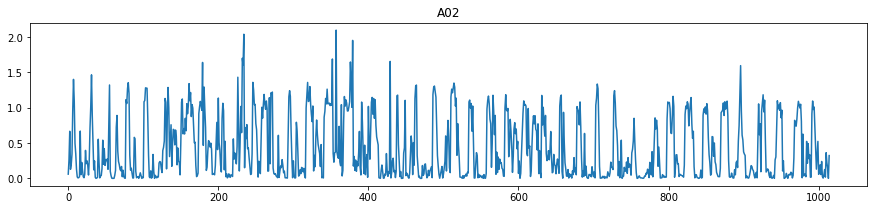

MovieWriter ffmpeg unavailable; using Pillow instead.


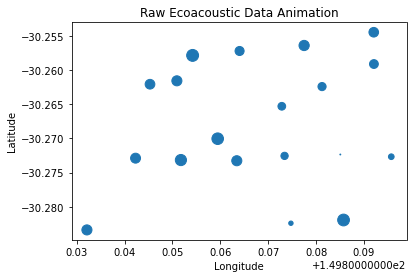

In [12]:
visualiser = Visualise()
site = 'A02'
single_site_data = preprocessor.get_single_site_data(ecoacoustic_data, site)
visualiser.plot_all_ts(single_site_data,site,'test')
visualiser.point_animation(ecoacoustic_data,metadata,'test')

<h2> III. Gaussian Process Regression spatiotemporal predictions </h2>

<a id="singlegp"></a>

<h3>a) Picture: single timeframe spatial gaussian process regression predictions</h3>

-Explanation here-


Initializing Model


C:\Users\samue\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\samue\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


This file already exists


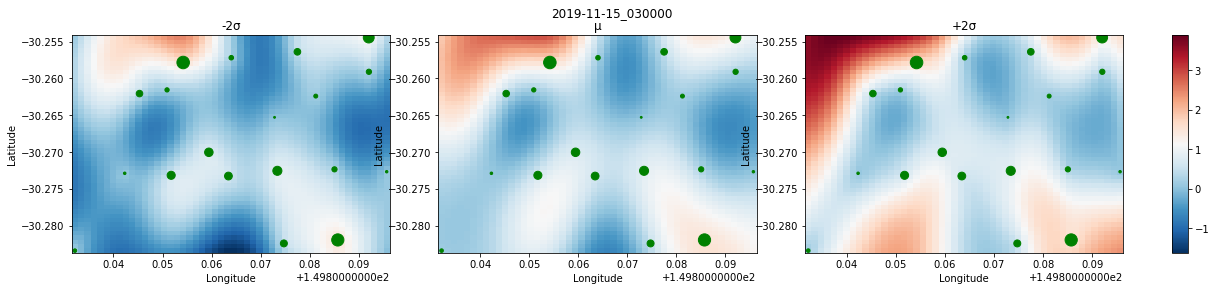

Initializing Model


C:\Users\samue\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\samue\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


This file already exists


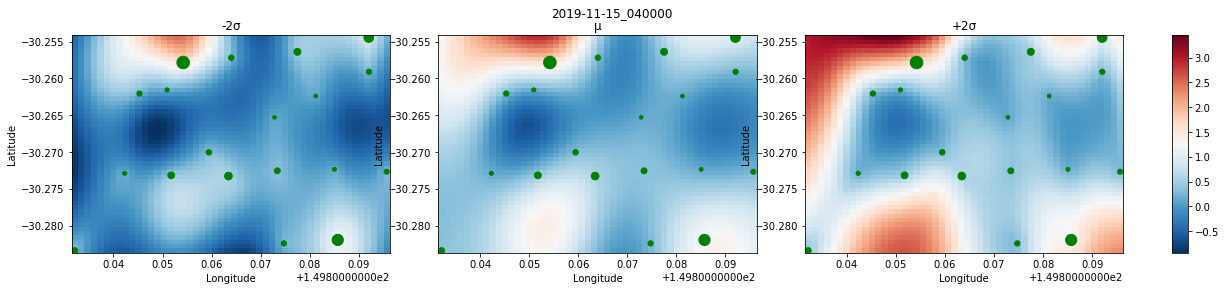

Initializing Model
This file already exists


C:\Users\samue\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\samue\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


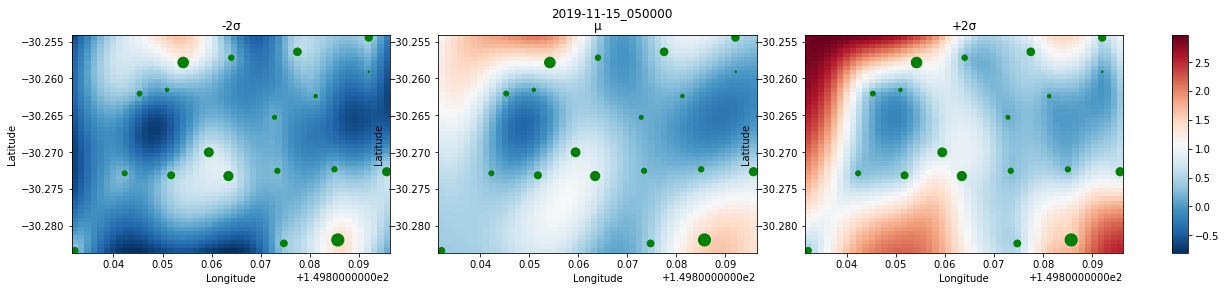

Initializing Model
This file already exists


C:\Users\samue\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\samue\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


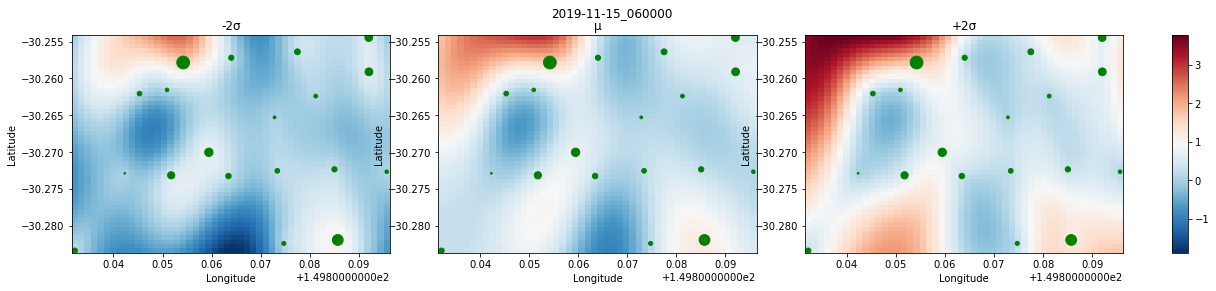

Initializing Model
This file already exists


C:\Users\samue\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\samue\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


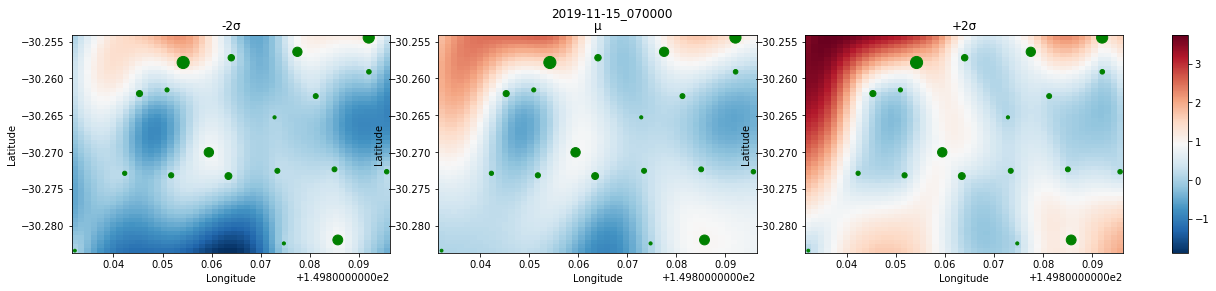

In [13]:
resolution = 50
for i in range(5):
    single_frame_data = preprocessor.get_single_frame_data(ecoacoustic_data,i)
    X_train = single_frame_data[['long','lat']].values
    y_train = single_frame_data.val.values
    
    single_frame_gp_model = SingleFrameGaussianProcessModel(title = ecoacoustic_data.index[i])
    single_frame_gp_model.train(X_train,y_train)
    
    x1 = np.linspace(np.min(single_frame_data.long), np.max(single_frame_data.long),resolution) #p
    x2 = np.linspace(np.min(single_frame_data.lat), np.max(single_frame_data.lat),resolution) #q
    x1x2 = np.array(list(product(x1, x2)))
    y_pred,y_lower,y_higher = single_frame_gp_model.predict(x1x2,plot=True)

<a id="fullgp"></a>

<h3>b) Video: spatiotemporal gaussian process regression predictions over the whole timeframe</h3>

-Explanation here-

Initializing Model
This file already exists
This file already exists


C:\Users\samue\anaconda3\lib\site-packages\matplotlib\animation.py:973: UserWarning: Animation was deleted without rendering anything. This is most likely unintended. To prevent deletion, assign the Animation to a variable that exists for as long as you need the Animation.
  warnings.warn(


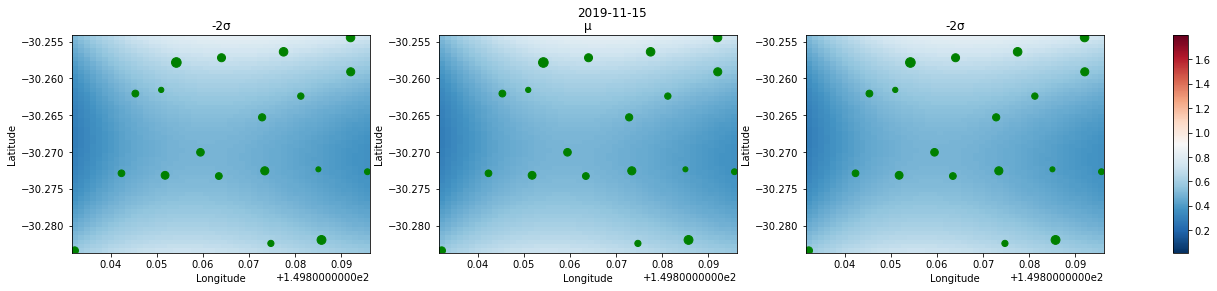

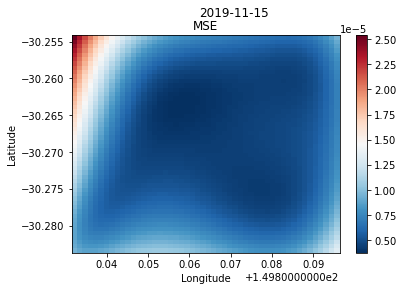

In [14]:
# Prepare data for Full GP
data_for_gp = preprocessor.get_data_for_full_gp(ecoacoustic_date_data,av_each_date = True)

# Initialize model
full_gp_model = FullGaussianProcessModel()

# Train model
X = data_for_gp[['long','lat','time']].values
y = data_for_gp.val.values
full_gp_model.train(X,y)

# Predict
resolution = 50
x1 = np.linspace(np.min(data_for_gp.long), np.max(data_for_gp.long),resolution)
x2 = np.linspace(np.min(data_for_gp.lat), np.max(data_for_gp.lat),resolution)
x3 = np.linspace(np.min(data_for_gp.time), np.max(data_for_gp.time),data_for_gp.time.unique().size)
x1x2x3 = np.array(list(product(x1, x2, x3)))
y_pred,y_lower,y_higher = full_gp_model.predict(x1x2x3,plot = True)

<h2> IV. Understanding the spatial and temporal variability in avian richness </h2>
<a id="tsmodel"></a>

<h3>a) Timeseries analysis </h3>

-Explanation here-

Initializing Model


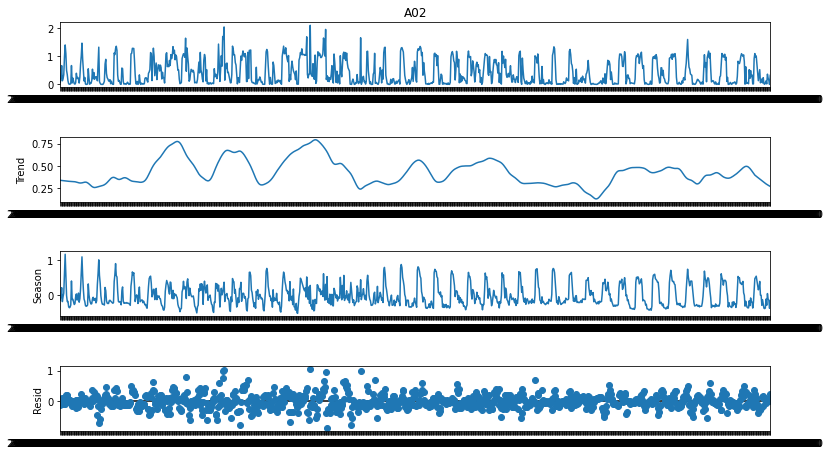

  0%|          | 0/13 [00:00<?, ?it/s]


NameError: name 'ARIMA' is not defined

In [15]:
site = 'A02'
single_site_data = preprocessor.get_single_site_data(ecoacoustic_data, site)

ts_model = TSModel(single_site_data, period=24)
decomposition = ts_model.seasonal_decompose()

data = ts_model.get_one_period_ahead_pred()

<a id="spatiotemporal"></a>

<h3>a) Spatiotemporal analysis </h3>

-Explanation here-

Analyzing!
This file already exists


C:\Users\samue\OneDrive\Documents\DARE Coursework\Final Project\code\analysis\svd_analysis.py:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  eof_plot = ax.pcolor(self.X0, self.X1, formatted_eof,cmap='RdBu_r')


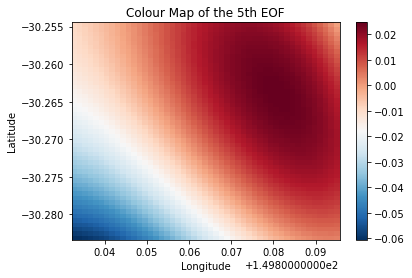

In [16]:
# SVD model
svd_model = SVDAnalysis(y_pred,data_for_gp.long.unique().size,'mean')
svd_model.show_EOF(resolution,5)